In [11]:
import os
import sys
import graphviz
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from time import time
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV

sys.path.append("../decision_tree")
from utils import tree_to_csv, CSV_HEADER

RANDOM_FOREST_CSV_FOLDER = os.path.join("./", "random_forest_trees_mfcc")
RANDOM_FOREST_CSV_BASENAME = "random_forest_trees"

### Extract the dataset from the .au csv files

In [12]:
print("Extracting dataset training set...")
dataset = '../../datasets/music_features_mfcc_train.csv'
musics_df = pd.read_csv(dataset, header=0)
# Get all style values
Y_train = musics_df["style"].values
# Get all features names
features_name = musics_df.columns.values[:-2]
# Get all features values
# musics_df = musics_df.drop('style', axis=1)
# musics_df = musics_df.drop('file_name', axis=1)
# X = musics_df.values
X_train = musics_df.loc[:, ~musics_df.columns.isin(['style', 'file_name'])].values
unique_label_names = np.unique(Y_train)

print("File contains {} unique_label_names: ".format(len(unique_label_names), unique_label_names))
print("File contains {} lines of {} data ".format(X_train.shape[0], X_train.shape[1]))

print("Extracting dataset testing set...")
dataset = '../../datasets/music_features_mfcc_test.csv'
musics_df = pd.read_csv(dataset, header=0)
# Get all style values
Y_test = musics_df["style"].values
# Get all features names
features_name = musics_df.columns.values[:-2]
# Get all features values
# musics_df = musics_df.drop('style', axis=1)
# musics_df = musics_df.drop('file_name', axis=1)
# X = musics_df.values
X_test = musics_df.loc[:, ~musics_df.columns.isin(['style', 'file_name'])].values
unique_label_names = np.unique(Y_test)

print("File contains {} unique_label_names: ".format(len(unique_label_names), unique_label_names))
print("File contains {} lines of {} data ".format(X_test.shape[0], X_test.shape[1]))

Extracting dataset training set...
File contains 10 unique_label_names: 
File contains 799 lines of 42 data 
Extracting dataset testing set...
File contains 10 unique_label_names: 
File contains 201 lines of 42 data 


# Random Forest Decision Tree

### Optimize the model using Grid search and cross validation

In [13]:
print("Creating Random Forest model...")
random_forest_model = RandomForestClassifier()

print("Training Random Forest model using grid search and cross validation...")
max_depth_list = list(range(1,20))
n_estimators_list = list(range(10,100,10))
max_depth_list.append(None)
max_samples_list = list(np.arange(0.1, 1.0, 0.1))
param_grid = dict(max_depth= max_depth_list, n_estimators=n_estimators_list, max_samples=max_samples_list)

random_forest_model = GridSearchCV(random_forest_model, param_grid, cv=5, verbose=2, n_jobs=os.cpu_count()-1)
t_start = time()
random_forest_model.fit(X_train, Y_train)
print("Training done in {}s".format(time()-t_start))

random_forest_best_estimator = random_forest_model.best_estimator_
print("Random Forest best estimator found using grid search: {}".format(random_forest_best_estimator))

Creating Random Forest model...
Training Random Forest model using grid search and cross validation...
Fitting 5 folds for each of 1620 candidates, totalling 8100 fits
[CV] END ......max_depth=1, max_samples=0.1, n_estimators=10; total time=   0.1s
[CV] END ......max_depth=1, max_samples=0.1, n_estimators=10; total time=   0.0s
[CV] END ......max_depth=1, max_samples=0.1, n_estimators=10; total time=   0.0s
[CV] END ......max_depth=1, max_samples=0.1, n_estimators=20; total time=   0.1s
[CV] END ......max_depth=1, max_samples=0.1, n_estimators=20; total time=   0.1s
[CV] END ......max_depth=1, max_samples=0.1, n_estimators=20; total time=   0.1s
[CV] END ......max_depth=1, max_samples=0.1, n_estimators=10; total time=   0.1s
[CV] END ......max_depth=1, max_samples=0.1, n_estimators=20; total time=   0.0s
[CV] END ......max_depth=1, max_samples=0.1, n_estimators=30; total time=   0.2s
[CV] END ......max_depth=1, max_samples=0.1, n_estimators=30; total time=   0.2s
[CV] END ......max_dep

### Create the final model using the best estimator found

Creating final Random Forest model...
Training final Random Forest model...
	training done in 0.4595029354095459s
Testing final Random Forest model...
              precision    recall  f1-score   support

       blues       0.83      0.71      0.77        21
   classical       0.86      0.90      0.88        20
     country       0.59      0.65      0.62        20
       disco       0.32      0.55      0.41        20
      hiphop       0.45      0.25      0.32        20
        jazz       0.82      0.45      0.58        20
       metal       0.65      0.85      0.74        20
         pop       0.78      0.70      0.74        20
      reggae       0.50      0.70      0.58        20
        rock       0.17      0.10      0.12        20

    accuracy                           0.59       201
   macro avg       0.60      0.59      0.58       201
weighted avg       0.60      0.59      0.58       201



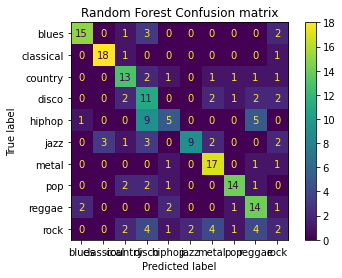

In [14]:
print("Creating final Random Forest model...")
random_forest_model = random_forest_best_estimator
print("Training final Random Forest model...")
t_start = time()
random_forest_model.fit(X_train,Y_train)
print("\ttraining done in {}s".format(time()-t_start))

print("Testing final Random Forest model...")
preds_valid=random_forest_model.predict(X_test)
# Metrics off the dataset
print(classification_report(Y_test, preds_valid, target_names=unique_label_names))
# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(Y_test, preds_valid, display_labels=unique_label_names)
plt.title("Random Forest Confusion matrix")
plt.show()

### Export model to csv file

In [15]:
if not os.path.exists(RANDOM_FOREST_CSV_FOLDER):
    os.makedirs(RANDOM_FOREST_CSV_FOLDER)
print("CSV file  path: {}".format(RANDOM_FOREST_CSV_FOLDER))

print("CSV file  header: {}".format(CSV_HEADER))


for i, tree in enumerate(random_forest_model.estimators_):
        tree_csv_file = os.path.join(RANDOM_FOREST_CSV_FOLDER, "{}_{}.csv".format(RANDOM_FOREST_CSV_BASENAME,i))
        tree_to_csv(tree=tree, class_names=unique_label_names, csv_file=tree_csv_file)


CSV file  path: ./random_forest_trees_mfcc
CSV file  header: ['node_id', 'threshold', 'feature_id', 'left_children_id', 'right_children_id', 'class']
